<a href="https://colab.research.google.com/github/alexisjkim/conformal_prediction_limitations/blob/main/Conformal_Prediction_Limitations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, Subset, TensorDataset
import torchvision

import pandas as pd
import cv2


In [286]:
# loading data and splitting into train, calibration, test sets

batch_size = 128

# this dataset has the training data from MNIST; will be split into training and calibration sets
mnist_train_set = torchvision.datasets.MNIST(root='./datasets/',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)



# this dataset has the test data from MNIST
mnist_test_dataset = torchvision.datasets.MNIST(root='./datasets',
                                          train=False,
                                          transform=torchvision.transforms.ToTensor())


train_percentage = 0.8 # this percentage of the training data set stays in the train set; the rest becomes part of the calibration set

train_size = int(train_percentage *len(mnist_train_set))
calibration_size = len(mnist_train_set) - train_size

mnist_train_set, mnist_cal_set = random_split(mnist_train_set, [train_size, calibration_size])

# Data loader
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

# We use drop_last=True to avoid the case where the data / batch_size != int

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print("SIZES OF DATASETS: ")
print("training set: ", len(mnist_train_loader.dataset))
print("calibration set: ", len(mnist_cal_loader.dataset))
print("testing set: ", len(mnist_test_loader.dataset))

SIZES OF DATASETS: 
training set:  48000
calibration set:  12000
testing set:  10000


In [287]:
# class for our neural network

class TwoLayerNetPiped(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        Parameters:
            D_in - dimensions of inputs
            H - number of hidden units per layer
            D_out - dimensions of outputs
        """
        # initialzing the parent object (important!)
        super(TwoLayerNetPiped, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        Parameters:
            x - tensor of inputs (shape: [BATCH_SIZE, D_in])
        """
        return self.pipe(x)

In [288]:
# Setting up the model

# hyper-parameters:
num_epochs = 8
learning_rate = 0.001

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Loss and optimizer
criterion = nn.CrossEntropyLoss()


In [289]:
# Train the model, given a training set in DataLoader form

def train_model(loader, model, optimizer):

    model.train()  # training mode
    total_step = len(loader)
    start_time = time.time()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            # each i is a batch of 128 samples
            images = images.to(device).view(batch_size, -1)  # represent images as column vectors
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize - ALWAYS IN THIS ORDER!
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), time.time() - start_time))

In [290]:
# create model, send it to device
og_model = TwoLayerNetPiped(D_in=28*28, H=256, D_out=10).to(device)

optimizer = torch.optim.Adam(og_model.parameters(), lr=learning_rate)

In [291]:
train_model(mnist_train_loader, og_model, optimizer)

Epoch [1/8], Step [100/375], Loss: 0.2583, Time: 0.3791 secs
Epoch [1/8], Step [200/375], Loss: 0.2261, Time: 0.7608 secs
Epoch [1/8], Step [300/375], Loss: 0.2773, Time: 1.1357 secs
Epoch [2/8], Step [100/375], Loss: 0.1479, Time: 1.7967 secs
Epoch [2/8], Step [200/375], Loss: 0.1009, Time: 2.1630 secs
Epoch [2/8], Step [300/375], Loss: 0.1512, Time: 2.5245 secs
Epoch [3/8], Step [100/375], Loss: 0.0656, Time: 3.1634 secs
Epoch [3/8], Step [200/375], Loss: 0.1330, Time: 3.5165 secs
Epoch [3/8], Step [300/375], Loss: 0.0591, Time: 3.8741 secs
Epoch [4/8], Step [100/375], Loss: 0.0802, Time: 4.4998 secs
Epoch [4/8], Step [200/375], Loss: 0.0514, Time: 4.8812 secs
Epoch [4/8], Step [300/375], Loss: 0.0977, Time: 5.2459 secs
Epoch [5/8], Step [100/375], Loss: 0.0896, Time: 5.9532 secs
Epoch [5/8], Step [200/375], Loss: 0.1384, Time: 6.3259 secs
Epoch [5/8], Step [300/375], Loss: 0.0413, Time: 6.6824 secs
Epoch [6/8], Step [100/375], Loss: 0.0916, Time: 7.3326 secs
Epoch [6/8], Step [200/3

In [292]:
# Prints out the accuracy of a model, given a model and the test data

def test_model(model, loader):

  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance), or use:
  with torch.no_grad(): # "don't keep track of the gradients" ,can also use .detach()
      correct = 0
      total = 0
      for images, labels in loader:
          images = images.to(device).view(images.size(0), -1) #image.size(0) returns batch size
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      #print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


test_model(og_model, mnist_test_loader)

In [293]:
# Takes in a model and a calibration/testing set, and returns: 1) a list of the softmaxes for each class, and 2) the indexes that have the highest softmaxes (aka predicted values)

def get_probabilities_and_predictions(model, loader):
    probs_list = []
    preds_list = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device).view(images.size(0), -1) # prepares image for input into model by flattening into a 1d vector
            outputs = model(images) # get output of the model when given the image as input
            probabilities = torch.nn.functional.softmax(outputs, dim = 1) #1 corresponds to columns
            #the prediction outputs the index of what it thinks the class is
            #the omitted term is the value
            _, predictions = torch.max(outputs.data, 1) # prediction = the index of the highest softmax value (aka the model's prediction). omitted term is the value 
            # Append to lists
            preds_list.extend(predictions.cpu().numpy())
            probs_list.extend(probabilities.cpu().numpy())

    return probs_list, preds_list

Conformal prediction starts here

In [294]:
# Given alpha value and a calibration set loader, returns the quantile (aka threshold for which all testing softmax scores below it should be ) 

def get_quantile(alpha, loader):

  cal_probs = []
  cal_preds = []
  cal_probs, cal_preds = get_probabilities_and_predictions(og_model, loader)

  cal_scores = []
  for prob, true_label in zip(cal_probs, cal_preds): #prob is the probability and true_label is index of pred
    true_class_prob = prob[true_label] #the corresponding lists with their prob function getting the most predicted class
    cal_scores.append(1 - true_class_prob) #s_i score

  cal_scores = np.array(cal_scores)
  sorted_scores = np.sort(cal_scores) #probabilities

  n = 0
  for _, labels in loader:
    n += labels.size(0)
    
  q_level = math.ceil((1 - alpha) * (n + 1)) / n

  
# print(f"Adjusted quantile level: {q_level}")
  return np.quantile(sorted_scores, min(1, q_level))




In [295]:
alpha = 0.05
threshold = get_quantile(alpha, mnist_cal_loader) #for the calibration set
print(threshold)

0.15976281364959094


In [296]:
# Returns prediction set

def conformal_prediction(probabilities, threshold):
    predictions = []
    for prob in probabilities:
        sorted_indices = np.argsort(prob)[::-1]
     #   total = 0.0
     #   prediction = []
     #   for i in sorted_indices:
        #    total += prob[i]
        #    prediction.append(i)
        #    if total > 1 - threshold: #we do 1 - threshold because we want to observe the right side as we are adding in ascending order
        #        break
        # predictions.append(prediction)

        prediction = []

        for i in range(len(prob)):
            if prob[i] >= 1 - threshold:
                prediction.append(i)

        predictions.append(prediction)
    return predictions





In [297]:
#evaluation
def evaluate_and_print(observed_labels, conformal_prediction, predicted, start_row, end_row, should_i_print=True):
  formatted_output = pd.DataFrame({
    'observed labels': observed_labels,
    'conformal prediction set': conformal_prediction,
    'prediction': predicted
  })


  #evaluation metric
  hits = 0
  total = len(observed_labels)
  for i in range(len(observed_labels)):
    conf_pred_row = conformal_prediction[i]
    observed = observed_labels[i]

    if observed in conf_pred_row:
      hits += 1

  score = hits/total *100

  if (should_i_print == False):
    print("the prediction was in the set ", score, " percent of the time")
    print(formatted_output[start_row:end_row])

  return score


In [298]:
#getting observed label functions
def get_observed_labels(loader):
    observed_labels = []
    with torch.no_grad():
        for images, labels in loader:
            observed_labels.extend(labels.cpu().numpy())
    return observed_labels

In [299]:
#evaluating our testing data set

test_observed_labels = get_observed_labels(mnist_test_loader)

test_probs = []
test_preds = []
test_probs, test_preds = get_probabilities_and_predictions(og_model, mnist_test_loader)


conformal_predictions = conformal_prediction(test_probs, threshold)
print("The conformal prediction accuracy based on training data and testing data from the same distribution is:")
train_test_same_score = evaluate_and_print(test_observed_labels, conformal_predictions, test_preds, 300, 450)



The conformal prediction accuracy based on training data and testing data from the same distribution is:


In [300]:
# PART 2: reducing the size of the calibration set

alpha = 0.05

cal_set_size = [] # x axis
accuracy_scores = [] # y axis
average_sizes = []

test_probs, test_preds = get_probabilities_and_predictions(og_model, mnist_test_loader) # Get the softmaxes and predictions from the test data set
labels = get_observed_labels(mnist_test_loader) # Get ground truth labels, and the softmaxes and predictions

for i in range(1, 500, 3):

    # Shrinks the  calibration set to be i elements, and makes it into a new loader called reduced_loader
    reduced_dataset = Subset(mnist_cal_loader.dataset, list(range(i)))
    reduced_loader = DataLoader(reduced_dataset, batch_size=batch_size, shuffle=False)

    print("size: ", len(reduced_loader.dataset))

    # Get threshold value based on the reduced_loader
    reduced_threshold = get_quantile(alpha, reduced_loader)

    # Get the conformal prediction sets for the reduced_loader based on the reduced_threshold
    reduced_conformal_predictions = conformal_prediction(test_probs, reduced_threshold)

    # i (size of calibration set) is the x axis for our graph
    cal_set_size.append(i)

    # reduced_score = the accuracy score of our reduced dataset; it is the y axis of our graph
    reduced_score = evaluate_and_print(labels, reduced_conformal_predictions, test_preds, 0, len(labels),True)


    sizes = [len(sublist) for sublist in reduced_conformal_predictions]
    total_size = sum(sizes)
    num_sublists = len(reduced_conformal_predictions)
    average_size = total_size / num_sublists
    average_sizes.append(average_size)

    accuracy_scores.append(reduced_score)
#   print("score: ", reduced_score)
    
    mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    
    

size:  1
size:  4
size:  7
size:  10
size:  13
size:  16
size:  19
size:  22
size:  25
size:  28
size:  31
size:  34
size:  37
size:  40
size:  43
size:  46
size:  49
size:  52
size:  55
size:  58
size:  61
size:  64
size:  67
size:  70
size:  73
size:  76
size:  79
size:  82
size:  85
size:  88
size:  91
size:  94
size:  97
size:  100
size:  103
size:  106
size:  109
size:  112
size:  115
size:  118
size:  121
size:  124
size:  127
size:  130
size:  133
size:  136
size:  139
size:  142
size:  145
size:  148
size:  151
size:  154
size:  157
size:  160
size:  163
size:  166
size:  169
size:  172
size:  175
size:  178
size:  181
size:  184
size:  187
size:  190
size:  193
size:  196
size:  199
size:  202
size:  205
size:  208
size:  211
size:  214
size:  217
size:  220
size:  223
size:  226
size:  229
size:  232
size:  235
size:  238
size:  241
size:  244
size:  247
size:  250
size:  253
size:  256
size:  259
size:  262
size:  265
size:  268
size:  271
size:  274
size:  277
size:  280
si

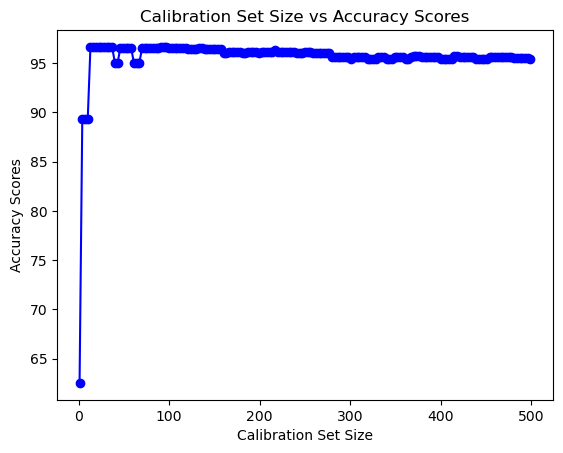

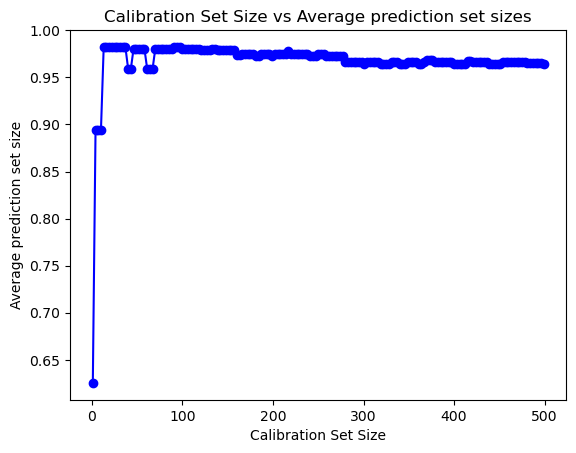

In [301]:
plt.plot(cal_set_size, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')  # Plot the data
plt.title('Calibration Set Size vs Accuracy Scores')
plt.xlabel('Calibration Set Size')
plt.ylabel('Accuracy Scores')
plt.show()


plt.plot(cal_set_size, average_sizes, marker='o', linestyle='-', color='b', label='Accuracy')  # Plot the data
plt.title('Calibration Set Size vs Average prediction set sizes')
plt.xlabel('Calibration Set Size')
plt.ylabel('Average prediction set size')
plt.show()

Repeating the experiment with test data that doesn't match the calibration set.

Functions for Blurring

In [302]:
def blur_images(image):
  return torch.tensor(cv2.blur(image.numpy(), (30, 30)))

In [303]:
#get blurred data
#blur the images
def get_blurred_data(loader):
    blurred_images = []
    blurred_labels = []

    # adding blur to every image in the training set
    with torch.no_grad():
        for images, labels in loader:
            for i in range(len(images)):
                blurred_image = blur_images(images[i])
                blurred_images.append(blurred_image)
                blurred_labels.append(labels[i])

    blurred_images = torch.stack(blurred_images)
    blurred_labels = torch.tensor(blurred_labels)

    return blurred_images, blurred_labels

In [304]:
def create_blur_loader(blurred_images, blurred_labels):
    # Create a TensorDataset and DataLoader for the blurred images
    blurred_dataset = TensorDataset(blurred_images, blurred_labels)
    blurred_loader = DataLoader(blurred_dataset, batch_size=128, shuffle=False)
    return blurred_loader

In [305]:
#testing our model on blurred images

blur_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


observed_labels = get_observed_labels(blur_loader)

blurred_images, blurred_labels = get_blurred_data(blur_loader)
blurred_loader = create_blur_loader(blurred_images, blurred_labels)

blur_probs = []
blur_preds = []
test_model(og_model, blurred_loader)
blur_probs, blur_preds = get_probabilities_and_predictions(og_model, blurred_loader)
'''''
blur_probs = []
blur_pred = []

# Flatten images for model input
blurred_images = blurred_images.view(len(blurred_images), -1).to(device)

#find probabilities and predictions
with torch.no_grad():
  outputs = model(blurred_images)
  probabilities = torch.nn.functional.softmax(outputs, dim = 1)
  _, blur_pred = torch.max(outputs.data, 1)


blur_preds = blur_pred.cpu().numpy()
blur_probs = probabilities.cpu().numpy()'''


conformal_predictions = conformal_prediction(blur_probs, threshold)
print("This is the conformal prediction accuracy based on training data and testing data from different distributions. \nThe training data contains normal images while the testing data were all blurred:")
train_blur_test_score = evaluate_and_print(observed_labels, conformal_predictions, blur_preds, 10, 200)



This is the conformal prediction accuracy based on training data and testing data from different distributions. 
The training data contains normal images while the testing data were all blurred:


Training on blurred Images

In [306]:
# Train the model -- additional training on blurred images without calibration


blurred_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                          batch_size=batch_size,
                                          shuffle=False)


observed_labels = get_observed_labels(blurred_train_loader)

blurred_images, blurred_labels = get_blurred_data(blurred_train_loader)
blurred_train_loader = create_blur_loader(blurred_images, blurred_labels)
blur_train_probs = []
blur_train_preds = []
blur_probs, blur_preds = get_probabilities_and_predictions(og_model, blurred_train_loader)


train_model(blurred_train_loader, og_model, optimizer)


Epoch [1/8], Step [100/375], Loss: 0.7807, Time: 0.1258 secs
Epoch [1/8], Step [200/375], Loss: 0.5389, Time: 0.2449 secs
Epoch [1/8], Step [300/375], Loss: 0.5438, Time: 0.3531 secs
Epoch [2/8], Step [100/375], Loss: 0.3114, Time: 0.5410 secs
Epoch [2/8], Step [200/375], Loss: 0.3184, Time: 0.6540 secs
Epoch [2/8], Step [300/375], Loss: 0.4258, Time: 0.7795 secs
Epoch [3/8], Step [100/375], Loss: 0.2130, Time: 0.9873 secs
Epoch [3/8], Step [200/375], Loss: 0.2357, Time: 1.1052 secs
Epoch [3/8], Step [300/375], Loss: 0.3812, Time: 1.2302 secs
Epoch [4/8], Step [100/375], Loss: 0.1728, Time: 1.4331 secs
Epoch [4/8], Step [200/375], Loss: 0.1930, Time: 1.5366 secs
Epoch [4/8], Step [300/375], Loss: 0.3471, Time: 1.6461 secs
Epoch [5/8], Step [100/375], Loss: 0.1490, Time: 1.8745 secs
Epoch [5/8], Step [200/375], Loss: 0.1676, Time: 1.9916 secs
Epoch [5/8], Step [300/375], Loss: 0.3126, Time: 2.1058 secs
Epoch [6/8], Step [100/375], Loss: 0.1301, Time: 2.2988 secs
Epoch [6/8], Step [200/3

In [314]:
#now use original calibration (the conformal predicition with the blurry images)

#creating blurry images again

blur_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

observed_labels = get_observed_labels(blur_test_loader)

blurred_images, blurred_labels = get_blurred_data(blur_test_loader)
blurred_test_loader = create_blur_loader(blurred_images, blurred_labels)


blur_test_preds = []
blur_test_probs = []

blur_test_probs, blur_test_preds = get_probabilities_and_predictions(og_model, blurred_test_loader)


conformal_predictions = conformal_prediction(blur_test_probs, threshold)
print("After putting additional training with blurred images with no recalibration:")
retrain_blur_norecal_score = evaluate_and_print(observed_labels, conformal_predictions, blur_test_preds, 100, 150)


After putting additional training with blurred images with no recalibration:


We want to compare 3 things
1) The original data
2) No retraing, no recalibration, feed test data with all blurred images
3) adding training but use original calibration, and feed blurred images

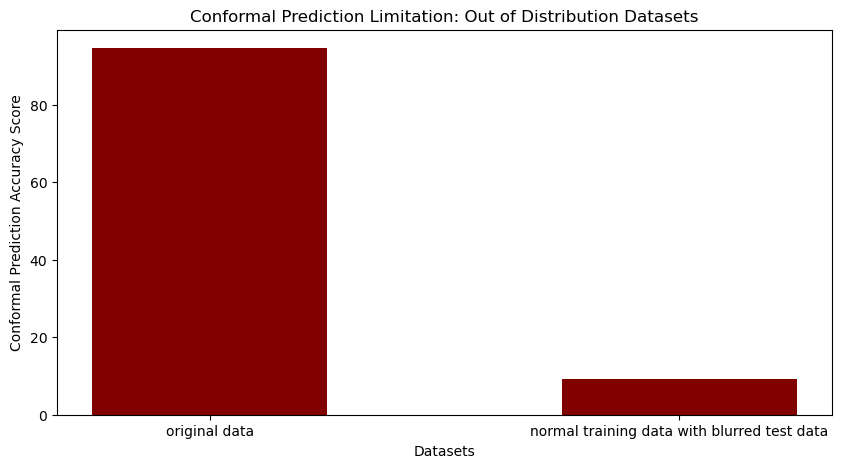

In [308]:
import matplotlib.pyplot as plt

data = {'original data': train_test_same_score, 
        'normal training data with blurred test data': train_blur_test_score}

training_or_testing_set = list(data.keys())
conformal_prediction_accuracy_score = list(data.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(training_or_testing_set, conformal_prediction_accuracy_score, color = 'maroon', width = 0.5)

plt.xlabel("Datasets")
plt.ylabel("Conformal Prediction Accuracy Score")
plt.title("Conformal Prediction Limitation: Out of Distribution Datasets")
plt.show()


In [309]:
#Now lets compare. lets calibrate the new blurred images
#Calibration of the blurred images

#blur everyother image in the calibration data


mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)


#blurs every other images
new_cal_images = []
new_cal_labels = []
with torch.no_grad():
    for images, labels in mnist_cal_loader:
        for i in range(len(images)):
          if i % 2 == 0:
            blurred_image = blur_images(images[i])
            new_cal_images.append(blurred_image)
            new_cal_labels.append(labels[i])
          else:
            new_cal_images.append(images[i])
            new_cal_labels.append(labels[i])


new_cal_images = torch.stack(new_cal_images)
new_cal_labels = torch.tensor(new_cal_labels)

new_cal_loader = create_blur_loader(new_cal_images, new_cal_labels)

new_cal_observed_labels = get_observed_labels(new_cal_loader)

alpha = 0.05
new_cal_threshold = get_quantile(alpha, new_cal_loader) #for the calibration set
print(new_cal_threshold)

#after calibrating get the accuracy
# we calibratted on 50:50 now we want to test on all blurred images

conformal_predictions = conformal_prediction(blur_test_probs, new_cal_threshold)
print("After putting additional training with blurred images with no recalibration:")
evaluate_and_print(observed_labels, conformal_predictions, blur_test_preds, 100, 150)


0.4149300200083563
After putting additional training with blurred images with no recalibration:


92.04

In [310]:
#sanity check -- what happens if you test with all non-bluured images with 50:50 calibration
test_probs = []
test_preds = []
test_probs, test_preds = get_probabilities_and_predictions(og_model, mnist_test_loader)



test_observed_labels = get_observed_labels(mnist_test_loader)
new_cal_normal_conformal_predictions = conformal_prediction(test_probs, new_cal_threshold)
print("The conformal prediction accuracy based on training data and testing data from the same distribution is:")
evaluate_and_print(test_observed_labels, new_cal_normal_conformal_predictions, test_preds, 300, 450)

The conformal prediction accuracy based on training data and testing data from the same distribution is:


17.41

In [315]:
def blur_some(loader, value):
    blur_count = 0
    non_blur_count = 0
    blur_some_images = []
    blur_some_labels = []
    with torch.no_grad():
        for images, labels in loader:
            for i in range(len(images)):
                if i > value: #the less the value of VALUE, the MORE blurred images
                    blurred_image = blur_images(images[i])
                    blur_some_images.append(blurred_image)
                    blur_some_labels.append(labels[i])
                    blur_count += 1
                else:
                    blur_some_images.append(images[i])
                    blur_some_labels.append(labels[i])
                    non_blur_count += 1


    blur_some_images = torch.stack(blur_some_images)
    blur_some_labels = torch.tensor(blur_some_labels)
    
    return blur_some_images,blur_some_labels

In [316]:
#Setting up new model
split_amount = 110
split_model = TwoLayerNetPiped(D_in=28*28, H=256, D_out=10).to(device)
optimizer = torch.optim.Adam(split_model.parameters(), lr=learning_rate)
num_epochs = 7

split_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                          batch_size=batch_size,
                                          shuffle=False)

split_images, split_labels = blur_some(split_train_loader, split_amount)
split_train_loader = create_blur_loader(split_images, split_labels)
train_model(split_train_loader, split_model, optimizer)



Epoch [1/7], Step [100/375], Loss: 0.4475, Time: 0.1187 secs
Epoch [1/7], Step [200/375], Loss: 0.3698, Time: 0.2341 secs
Epoch [1/7], Step [300/375], Loss: 0.5090, Time: 0.3545 secs
Epoch [2/7], Step [100/375], Loss: 0.2201, Time: 0.5531 secs
Epoch [2/7], Step [200/375], Loss: 0.2098, Time: 0.6652 secs
Epoch [2/7], Step [300/375], Loss: 0.3818, Time: 0.7779 secs
Epoch [3/7], Step [100/375], Loss: 0.1350, Time: 0.9766 secs
Epoch [3/7], Step [200/375], Loss: 0.1365, Time: 1.0807 secs
Epoch [3/7], Step [300/375], Loss: 0.3128, Time: 1.1890 secs
Epoch [4/7], Step [100/375], Loss: 0.0933, Time: 1.3964 secs
Epoch [4/7], Step [200/375], Loss: 0.0975, Time: 1.5151 secs
Epoch [4/7], Step [300/375], Loss: 0.2551, Time: 1.6386 secs
Epoch [5/7], Step [100/375], Loss: 0.0695, Time: 1.8428 secs
Epoch [5/7], Step [200/375], Loss: 0.0788, Time: 1.9649 secs
Epoch [5/7], Step [300/375], Loss: 0.2180, Time: 2.0823 secs
Epoch [6/7], Step [100/375], Loss: 0.0580, Time: 2.2868 secs
Epoch [6/7], Step [200/3

In [317]:
#recalibrate


split_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                          batch_size=batch_size,
                                          shuffle=False)

split_cal_images, split_cal_labels = blur_some(split_cal_loader, split_amount)
split_cal_loader = create_blur_loader(split_cal_images, split_cal_labels)

alpha = 0.05
split_cal_threshold = get_quantile(alpha, split_cal_loader) #for the calibration set
print(split_cal_threshold)

0.4138012503584226


In [334]:
#now retest -- get testing data
split_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


scores = []
for i in range(batch_size + 1):
    split_images, split_labels = blur_some(split_test_loader, i)
    split_test_loader = create_blur_loader(split_images, split_labels)
    test_model(split_model, split_test_loader)

    split_test_preds = []
    split_test_probs = []

    split_test_probs, split_test_preds = get_probabilities_and_predictions(split_model, split_test_loader)
    split_observed_labels = get_observed_labels(split_test_loader)

    conformal_predictions = conformal_prediction(split_test_probs, split_cal_threshold)
    print (i , " ", evaluate_and_print(split_observed_labels, conformal_predictions, split_test_preds, 100, 150))

    scores.append(evaluate_and_print(split_observed_labels, conformal_predictions, split_test_preds, 100, 150))
    split_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)
    

print(scores)

0   73.61
1   73.8
2   74.02
3   74.22
4   74.36
5   74.53
6   74.74
7   74.98
8   75.14
9   75.4
10   75.53999999999999
11   75.7
12   75.91
13   76.12
14   76.29
15   76.48
16   76.64
17   76.77000000000001
18   77.0
19   77.16
20   77.32
21   77.58
22   77.73
23   77.85
24   78.0
25   78.13
26   78.27
27   78.36
28   78.51
29   78.66
30   78.84
31   79.08
32   79.23
33   79.38
34   79.58
35   79.77
36   79.91
37   80.08
38   80.25999999999999
39   80.43
40   80.58999999999999
41   80.72
42   80.93
43   81.06
44   81.26
45   81.45
46   81.55
47   81.69
48   81.89999999999999
49   82.07
50   82.28999999999999
51   82.54
52   82.76
53   82.83
54   83.05
55   83.3
56   83.41
57   83.62
58   83.81
59   84.05
60   84.23
61   84.45
62   84.67
63   84.91
64   85.05
65   85.26
66   85.49
67   85.72
68   85.95
69   86.15
70   86.33999999999999
71   86.46000000000001
72   86.61999999999999
73   86.77
74   86.98
75   87.13
76   87.31
77   87.46000000000001
78   87.56
79   87.69
80   87.88
81   

129
129


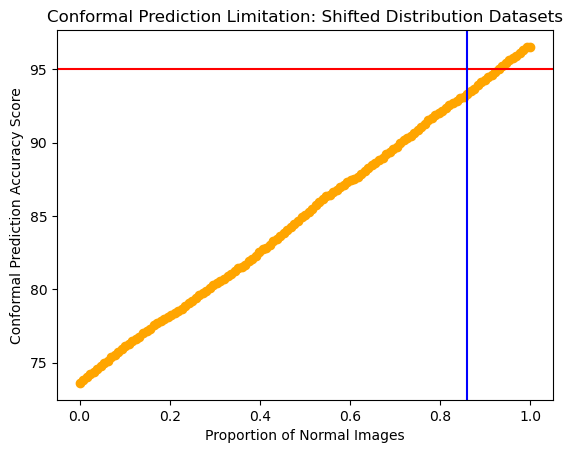

In [340]:
dem = np.full(129, 128)
num = np.linspace(0, 128, num = 129)
proportion_normal = np.divide(num,dem)



import matplotlib.pyplot as plt
print(len(scores))
print(len(proportion_normal))

x = proportion_normal
y = scores
fig = plt.plot(figsize = (10, 5))
plt.scatter(x, y, color = 'orange')
# specifying horizontal line type 
plt.axhline(y = 95, color = 'r', linestyle = '-') 
plt.axvline(x = split_amount/batch_size, color = 'b', linestyle = '-' )

plt.xlabel("Proportion of Normal Images")
plt.ylabel("Conformal Prediction Accuracy Score")
plt.title("Conformal Prediction Limitation: Shifted Distribution Datasets")
plt.show()


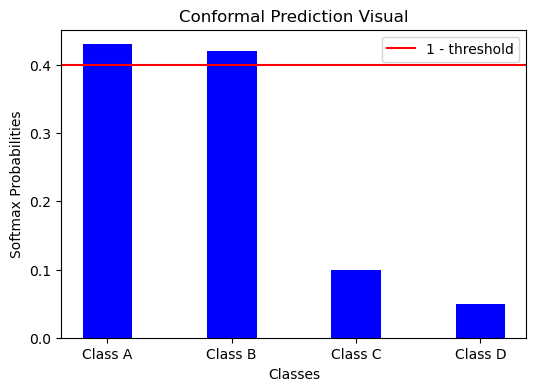

In [347]:
#fake data
data = {'Class A': 0.43,
        'Class B': 0.42,
        'Class C': 0.10,
        'Class D': 0.05,
}

threshold = 0.6

classes = list(data.keys())
softmax = list(data.values())

fig, axs = plt.subplots(figsize=(6, 4))
axs.bar(classes, softmax, color = 'blue', width = 0.4)
axs.axhline(y = 1 - threshold, color = 'r', linestyle = '-', label = '1 - threshold') 

plt.xlabel("Classes")
plt.ylabel("Softmax Probabilities")
plt.title("Conformal Prediction Visual")
plt.legend()
plt.show()


In [250]:
'''''import cv2



rotate_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

observed_labels = []
with torch.no_grad():
    for images, labels in mnist_test_loader:
        observed_labels.extend(labels.cpu().numpy())


def rotate_image(image):
    image = image.numpy().squeeze()  # Convert to numpy array and remove batch dimension
    rows, cols = image.shape
    rotated_image = cv2.warpAffine(image, dsize=None, M=cv2.getRotationMatrix2D((cols / 2, rows / 2), -120, 1))
    return torch.tensor(rotated_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension back

rotated_images = []
rotated_labels = []

with torch.no_grad():
    for images, labels in mnist_test_loader:
        for i in range(len(images)):
            rotated_image = rotate_image(images[i])
            rotated_images.append(rotated_image)
            rotated_labels.append(labels[i])


rotated_images = torch.stack(rotated_images)
rotated_labels = torch.tensor(rotated_labels)

# Evaluate the model on the rotated test set
rotate_probs = []
rotate_preds = []

# Flatten images for model input
rotated_images = rotated_images.view(len(rotated_images), -1).to(device)


# Evaluate the model on the entire rotated test set at once
with torch.no_grad():
    outputs = model(rotated_images) #
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, rotate_preds = torch.max(outputs.data, 1)

rotate_preds = rotate_preds.cpu().numpy()
rotate_probs = probabilities.cpu().numpy()

conformal_predictions = conformal_prediction(rotate_probs, threshold)
print("flip evaluation:")
evaluate_and_print(observed_labels, conformal_predictions, rotate_preds, 10, 200)

'''''


'\'\'import cv2\n\n\n\nrotate_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,\n                                          batch_size=batch_size,\n                                          shuffle=False)\n\nobserved_labels = []\nwith torch.no_grad():\n    for images, labels in mnist_test_loader:\n        observed_labels.extend(labels.cpu().numpy())\n\n\ndef rotate_image(image):\n    image = image.numpy().squeeze()  # Convert to numpy array and remove batch dimension\n    rows, cols = image.shape\n    rotated_image = cv2.warpAffine(image, dsize=None, M=cv2.getRotationMatrix2D((cols / 2, rows / 2), -120, 1))\n    return torch.tensor(rotated_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension back\n\nrotated_images = []\nrotated_labels = []\n\nwith torch.no_grad():\n    for images, labels in mnist_test_loader:\n        for i in range(len(images)):\n            rotated_image = rotate_image(images[i])\n            rotated_images.append(rotated_image)\n            